# Classifier with CNNs

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
BATCH_SIZE = 128
N_EPOCHS = 15
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNELS = 1

## Dataset
The used dataset is the iconic MNIST database of handwritten digits. As the distribution of training and test set is not .7 and .3 as needed for the assignment, some of the training data was randomly moved to the test set.

In [3]:
# Download dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape dataset to match Keras API
# (size, x, y, channels)
x_train = x_train.reshape(x_train.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
x_test = x_test.reshape(x_test.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [4]:
x_test = np.append(x_test, x_train[49000:], axis=0)
x_train = x_train[:49000]

y_test = np.append(y_test, y_train[49000:], axis=0)
y_train = y_train[:49000]

print(f'x train: {len(x_train)}, x test: {len(x_test)}')
print(f'y train: {len(y_train)}, y test: {len(y_test)}')
total = len(x_train)+len(x_test)
print(f'training set part: {len(x_train)/total}, test set part: {len(x_test)/total}')

x train: 49000, x test: 21000
y train: 49000, y test: 21000
training set part: 0.7, test set part: 0.3


## Dataset Generator with Augmentation

In [5]:
train_data_gen = ImageDataGenerator(
    # rescale pixel values [0, 255] to [0, 1]
    rescale=1./255, 
    # augmentation:
    ## allow some rotation 
    rotation_range=45,
    ## allow to shift whole image
    width_shift_range=.2,
    height_shift_range=.2,
    fill_mode="nearest",
    ## allow some zoom
    zoom_range=.15
    ).flow(x_train, y_train, batch_size=BATCH_SIZE)

test_data_gen = ImageDataGenerator(
    rescale=1./255
    # dont apply augmentation in test set
    ).flow(x_test, y_test, batch_size=BATCH_SIZE)

In [50]:
def plotImages(title, images_arr, subtitles=None):
    fig, axes = plt.subplots(1, len(images_arr))
    fig.suptitle(title, fontsize=20, y=.80)

    axes = axes.flatten()
    for i in range(len(images_arr)):
        img = images_arr[i]
        ax = axes[i]
        subtitle = subtitles[i] if subtitles is not None else None
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(subtitle)

    plt.tight_layout()
    plt.show()

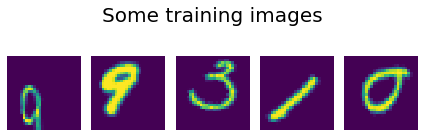

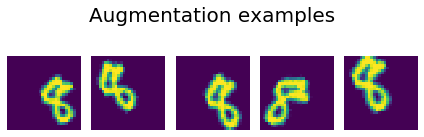

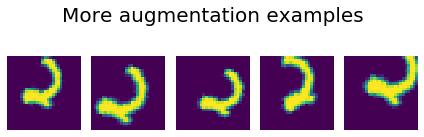

In [51]:
vis_elements = 5
augmented_images, y = next(train_data_gen)
plotImages('Some training images', augmented_images[:vis_elements].reshape(vis_elements, IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0].reshape(IMG_HEIGHT, IMG_WIDTH) for i in range(vis_elements)]
plotImages('Augmentation examples', augmented_images)

augmented_images = [train_data_gen[0][0][1].reshape(IMG_HEIGHT, IMG_WIDTH) for i in range(vis_elements)]
plotImages('More augmentation examples', augmented_images)

## Building the model

In [8]:
# build the layers
model = Sequential([
    # convolution over image with 
    ## nr of filters aka depth of the resulting convolution result
    ## kernel size for the convolution
    ## padding if the kernel is placed at the borders
    ## activation function of the result
    ## shape of the input (as it's the first layer)
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    # pooling for the results from previous layer by taking max value with pooling size (2, 2)
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    # flattens the previous result into one dimension (concat of multidimensional results)
    Flatten(),
    # fully connected layer
    Dense(512, activation='relu'),
    # final fully connected layer with 
    ## number of output values = nr of classes
    ## activation function is softmax to create probabilities
    Dense(10, activation='softmax')
])

# compile the architecture
model.compile(
              # optimizer for applying updates
              optimizer='adam',
              # sparse categorical instead of binary as we have more than two classes
              loss='sparse_categorical_crossentropy',
              # the metrics to show while training and on evaluations
              metrics=['accuracy']
              )

# print a summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

### Loss function
The loss function is used to determine how far away the generated results during training are compared to ground truth. In an optimal case, all predictions should match the given labels which results in a loss of 0.
#### Binary Crossentropy
This loss function calculates the loss for two classes (true or false). If the real value is 1 the loss is log(P(1)). If the real value is 0 the loss is log(1-P(1)) = log(P(0)). P(1) is the predicted probability for the current input to be 1. The individual losses are averaged over all training inputs. As the result of log(x) with 1>x>0 is negative the overall result is multiplied by -1. <br/>
Using the log function matches the formula for entropy, with the difference that this one adds the log probabilities for all classes and does not calculate the average.
#### Categorical Crossentropy 
I used sparse categorical crossentropy as this also works with more than two classes.

## Training the model

In [9]:
history = model.fit(
                    # training data provided by generator
                    train_data_gen,
                    # steps per epoch calculated that all training data is seen once per epoch
                    steps_per_epoch=len(x_train)/BATCH_SIZE,
                    # number of epochs
                    epochs=N_EPOCHS,
                    # test data to visualize results later in plot
                    validation_data=test_data_gen,
                    # steps after each epoch for test data
                    validation_steps=len(x_test)/BATCH_SIZE
                    )

Epoch 1/15
383/382 [==============================] - 14s 37ms/step - loss: 0.8258 - accuracy: 0.7276 - val_loss: 0.1685 - val_accuracy: 0.9488
Epoch 2/15
383/382 [==============================] - 14s 36ms/step - loss: 0.2681 - accuracy: 0.9163 - val_loss: 0.1087 - val_accuracy: 0.9651
Epoch 3/15
383/382 [==============================] - 14s 36ms/step - loss: 0.1895 - accuracy: 0.9405 - val_loss: 0.0974 - val_accuracy: 0.9681
Epoch 4/15
383/382 [==============================] - 14s 37ms/step - loss: 0.1488 - accuracy: 0.9531 - val_loss: 0.0847 - val_accuracy: 0.9737
Epoch 5/15
383/382 [==============================] - 27s 70ms/step - loss: 0.1331 - accuracy: 0.9579 - val_loss: 0.0650 - val_accuracy: 0.9794
Epoch 6/15
383/382 [==============================] - 21s 55ms/step - loss: 0.1163 - accuracy: 0.9631 - val_loss: 0.0605 - val_accuracy: 0.9809
Epoch 7/15
383/382 [==============================] - 14s 36ms/step - loss: 0.1088 - accuracy: 0.9661 - val_loss: 0.0663 - val_accuracy:

## Visualization of Results

In [ ]:
model.evaluate(x_test, y_test)

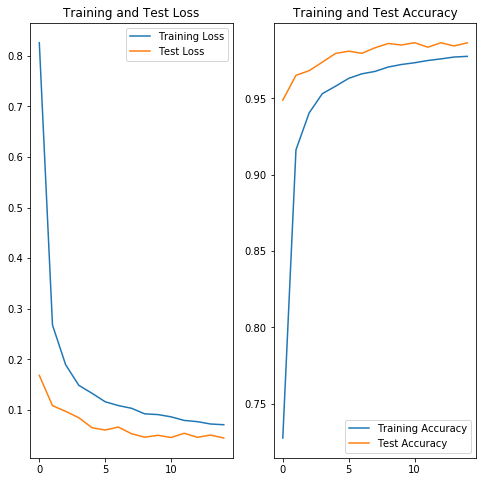

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(N_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')
plt.show()

Visualized results here are final loss and accuracy after each epoch. <br />
As the training improves the prediction results, the resulting loss decreases. Simultaneously, the accuracy improves with better predictions.

This is the result with a lot of augmented data. The accuracy of the test set is even better than the one from the training set, as it is less noisy and therefore easier to classify. Mentionable here is also the (almost) constant increase in accuracy which means there is not much overfitting.

Before the training data augmentation, loss and accuracy had a lot of large hops from better to worse again which can be a sign of overfitting. Also the test set accuracy was constantly worse than the training set accuracy. Dropout layers did not contribute much to the final result, so they were removed in favor of a simpler network architecture.

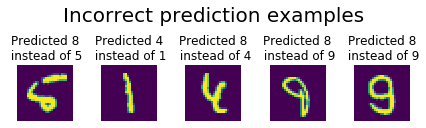

In [52]:
y_pred = model.predict(x_test)
x = [(x_test[i], y_test[i], np.argmax(y_pred[i])) for i in range(len(y_pred)) if y_test[i] != np.argmax(y_pred[i])][:5]

plotImages('Incorrect prediction examples', 
           [f.reshape(IMG_HEIGHT, IMG_WIDTH) for f, _, _ in x], 
           subtitles=[f"Predicted {t}\n instead of {s}" for _, s, t in x]
           )